In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.distributions import Normal
import random

def set_seed(seed: int = 11) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    print(f"Random seed set as {seed}")


class PPO(nn.Module):
    def __init__(self, state_dim, action_dim, gamma=0.99, batch_size=128, 
                 epsilon=0.2, epoch_n=30, pi_lr=1e-4, v_lr=5e-4):

        super().__init__()
        
        self.pi_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                      nn.Linear(128, 128), nn.ReLU(),
                                      nn.Linear(128, action_dim * 2), nn.Tanh())
        
        self.v_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                     nn.Linear(128, 128), nn.ReLU(),
                                     nn.Linear(128, 1))
        
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epoch_n = epoch_n
        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), lr=pi_lr)
        self.v_optimizer = torch.optim.Adam(self.v_model.parameters(), lr=v_lr)

    def get_action(self, state):
        mean1, mean2, log_std1, log_std2 = self.pi_model(torch.FloatTensor(state))
        dist1 = Normal(mean1, torch.exp(log_std1))
        dist2 = Normal(mean2, torch.exp(log_std2))
        action1 = dist1.sample()
        action2 = dist2.sample()
        return np.array([action1.numpy(), action2.numpy()])

    def fit(self, states, actions, next_states, rewards, dones):
        
        states, actions, next_states, rewards, dones = map(np.array, [states, actions, next_states, rewards, dones])
        rewards, dones = rewards.reshape(-1, 1), dones.reshape(-1, 1)

        returns = np.zeros(rewards.shape)
        returns[-1] = rewards[-1]
        
        for t in range(returns.shape[0] - 2, -1, -1):
            returns[t] = rewards[t] + (1 - dones[t]) * self.gamma * returns[t + 1]

        states, actions, next_states, rewards, returns = map(torch.FloatTensor, [states, actions, next_states, rewards, returns])
    
        mean1, mean2, log_std1, log_std2 = self.pi_model(states).T
        mean1, mean2, log_std1, log_std2 = mean1.unsqueeze(1), mean2.unsqueeze(1), log_std1.unsqueeze(1), log_std2.unsqueeze(1)
        dist1 = Normal(mean1, torch.exp(log_std1))
        dist2 = Normal(mean2, torch.exp(log_std2))
        old_log_probs = torch.concat([dist1.log_prob(actions[:, 0].reshape(-1, 1)), dist2.log_prob(actions[:, 1].reshape(-1, 1))], axis=1).detach()
        
        for epoch in range(self.epoch_n):
            
            idxs = np.random.permutation(returns.shape[0])
            for i in range(0, returns.shape[0], self.batch_size):
                b_idxs = idxs[i: i + self.batch_size]
                b_states = states[b_idxs]
                b_actions = actions[b_idxs]
                b_returns = returns[b_idxs]
                b_rewards = rewards[b_idxs]
                b_next_states = next_states[b_idxs]
                b_old_log_probs = old_log_probs[b_idxs]
    
                # b_advantage = b_returns.detach() - self.v_model(b_states)
                
                b_advantage = b_rewards.detach() + self.gamma * self.v_model(b_next_states) - self.v_model(b_states)
                
                b_mean1, b_mean2, b_log_std1, b_log_std2 = self.pi_model(b_states).T
                b_mean1, b_mean2, b_log_std1, b_log_std2 = b_mean1.unsqueeze(1), b_mean2.unsqueeze(1), b_log_std1.unsqueeze(1), b_log_std2.unsqueeze(1)
                b_dist1 = Normal(b_mean1, torch.exp(b_log_std1))
                b_dist2 = Normal(b_mean2, torch.exp(b_log_std2))
                b_new_log_probs = torch.concat([b_dist1.log_prob(b_actions[:, 0].reshape(-1, 1)), b_dist2.log_prob(b_actions[:, 1].reshape(-1, 1))], axis=1)
    
                b_ratio = torch.exp(b_new_log_probs - b_old_log_probs)
                pi_loss_1 = b_ratio * b_advantage.detach()
                pi_loss_2 = torch.clamp(b_ratio, 1. - self.epsilon,  1. + self.epsilon) * b_advantage.detach()
                pi_loss = - torch.mean(torch.min(pi_loss_1, pi_loss_2))
                
                pi_loss.backward()
                self.pi_optimizer.step()
                self.pi_optimizer.zero_grad()
                
                v_loss = torch.mean((self.v_model(b_states) - b_returns.detach())**2)

                v_loss.backward()
                self.v_optimizer.step()
                self.v_optimizer.zero_grad()

epoch: 0, reward: -400.0564210117625
epoch: 1, reward: -55.80181739948472
epoch: 2, reward: -35.583874027551474
epoch: 3, reward: 74.06523624509133
epoch: 4, reward: 86.93662025074815
epoch: 5, reward: 111.74695015955565
epoch: 6, reward: 133.02261486541647
epoch: 7, reward: 162.88367641250218
epoch: 8, reward: 129.20627431694442
epoch: 9, reward: 98.66895582172546
epoch: 10, reward: 165.78021011106057
epoch: 11, reward: 148.64467983903955
epoch: 12, reward: 149.1243090046502
epoch: 13, reward: 159.32867342609015
epoch: 14, reward: 161.93621844167203
epoch: 15, reward: 153.66762217809654
epoch: 16, reward: 171.5545061938301
epoch: 17, reward: 165.0323074828468
epoch: 18, reward: 175.66869572793937
epoch: 19, reward: 72.2980803971632
epoch: 20, reward: 177.32994658801442
epoch: 21, reward: -31.335260465173313
epoch: 22, reward: 176.26940599723588
epoch: 23, reward: 156.82551595346956
epoch: 24, reward: 276.0839314941844
epoch: 25, reward: 296.63387789631327
epoch: 26, reward: 188.334665

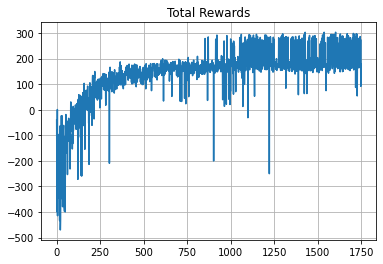

In [2]:
env = gym.make('LunarLander-v2', continuous = True)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

epoch_n = 50
episode_n = 35
trajectory_n = 50

agent = PPO(state_dim, action_dim, epoch_n=epoch_n)


total_rewards = []

for episode in range(episode_n):

    next_states, states, actions, rewards, dones = [], [], [], [], []

    for _ in range(trajectory_n):
        total_reward = 0

        state = env.reset()
        for t in range(500):
            states.append(state)
            
            action = agent.get_action(state)
            actions.append(action)
            
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            dones.append(done)
            next_states.append(state)

            total_reward += reward
            
            if done:
                break

        total_rewards.append(total_reward)

    agent.fit(states, actions, next_states, rewards, dones)
    
    print(f"epoch: {episode}, reward: {total_reward}")

plt.plot(total_rewards)
plt.title('Total Rewards')
plt.grid()
plt.show()